# Evaluate Simple AE per Anomaly Class

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics
from utils.evalUtils import print_confusion_matrix

import joblib

## Preperations

In [2]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [3]:
%run -i ./scripts/setConfigs.py

Set configs..


In [4]:
%run -i ./scripts/EvalPreperations.py

Set configs..
Read the data..
Shape of normal data (X_sim): (105216, 17)
Shape of anormal data (X_test): (35040, 18)
Shape of drifted data (X_drifted): (35040, 18)
Shape of drifted anormal data (X_drifted,anormal): (35040, 19)
Save label..
Shape of anormal data (X_test): (35040, 17)
Shape of drifted data (X_drifted): (35040, 17)
Shape of drifted anormal data (X_drifted,anormal): (35040, 17)
Scale data..
Prepare data for PyTorch..


## Read AE & LogReg

In [5]:
%run -i ./scripts/ReadSimpleAE_MetaModel.py

Load Meta Model AE..
/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200319_firstMetaModel.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


In [6]:
type(meta_model)

models.SimpleAutoEncoder.SimpleAutoEncoder

In [7]:
model = meta_model
type(model)

models.SimpleAutoEncoder.SimpleAutoEncoder

In [8]:
%run -i ./scripts/ReadLogReg_Meta.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [9]:
clf = clf_meta
type(clf)

sklearn.linear_model._logistic.LogisticRegression

## Evaluation

### On X_test

In [10]:
df_x_test = pd.DataFrame(scaled_anormal)

In [11]:
df_x_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.492913,-0.474743,-0.301436,-0.356423,-0.601364,-0.635563,-0.647363,-0.648449,-0.646976,-0.597815,-0.862852,-0.866244,0.440097,0.492273,0.793462,-0.547574,-0.862468
1,-0.505906,-0.489319,-0.310264,-0.372325,-0.599158,-0.622188,-0.675583,-0.676633,-0.675202,-0.615325,-0.846472,-0.849955,0.453095,0.506418,0.807068,-0.560736,-0.846042
2,-0.516472,-0.501424,-0.317097,-0.385840,-0.595586,-0.608352,-0.700501,-0.701514,-0.700127,-0.630084,-0.835318,-0.838847,0.463743,0.518097,0.816319,-0.571394,-0.834857
3,-0.533592,-0.519612,-0.331012,-0.404536,0.306616,-0.605617,-0.728748,-0.729715,-0.728384,-0.651311,-0.822841,-0.826408,0.480644,0.536055,0.826656,-0.589021,-0.822345
4,-0.568562,-0.554805,-0.363015,-0.438289,0.277754,-0.625982,-0.770153,-0.771041,-0.769808,-0.690881,-0.799175,-0.802784,0.514673,0.571425,0.846239,-0.625467,-0.798613


In [12]:
s_labels.reset_index(drop=True, inplace=True)

In [13]:
df_x_test['anomaly_labels'] = s_labels

In [14]:
losses_anormal = []
for val in anormal_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_anormal.append(loss.item())
    
s_losses_anormal = pd.Series(losses_anormal)

In [15]:
X = s_losses_anormal.to_numpy()
X = X.reshape(-1, 1)

In [16]:
predictions_anormal = []
for val in X:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions_anormal.append(pred[0])

In [17]:
df_x_test['ano_predictions']  = predictions_anormal

In [18]:
df_x_test['reconstruction_error'] = s_losses_anormal

In [19]:
df_x_test.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,anomaly_labels,ano_predictions,reconstruction_error
0,-0.492913,-0.474743,-0.301436,-0.356423,-0.601364,-0.635563,-0.647363,-0.648449,-0.646976,-0.597815,-0.862852,-0.866244,0.440097,0.492273,0.793462,-0.547574,-0.862468,0.0,0,0.008744
1,-0.505906,-0.489319,-0.310264,-0.372325,-0.599158,-0.622188,-0.675583,-0.676633,-0.675202,-0.615325,-0.846472,-0.849955,0.453095,0.506418,0.807068,-0.560736,-0.846042,0.0,0,0.008935
2,-0.516472,-0.501424,-0.317097,-0.385840,-0.595586,-0.608352,-0.700501,-0.701514,-0.700127,-0.630084,-0.835318,-0.838847,0.463743,0.518097,0.816319,-0.571394,-0.834857,0.0,0,0.009293
3,-0.533592,-0.519612,-0.331012,-0.404536,0.306616,-0.605617,-0.728748,-0.729715,-0.728384,-0.651311,-0.822841,-0.826408,0.480644,0.536055,0.826656,-0.589021,-0.822345,2.0,0,0.072726
4,-0.568562,-0.554805,-0.363015,-0.438289,0.277754,-0.625982,-0.770153,-0.771041,-0.769808,-0.690881,-0.799175,-0.802784,0.514673,0.571425,0.846239,-0.625467,-0.798613,2.0,0,0.072906
5,-0.614759,-0.600641,-0.406691,-0.481397,0.233781,-0.662315,-0.819121,-0.819895,-0.818811,-0.741916,-0.768903,-0.772522,0.559531,0.617762,0.871254,-0.673760,-0.768257,2.0,0,0.072612
6,-0.664226,-0.649147,-0.453336,-0.526079,0.184694,-0.705052,-0.867957,-0.868586,-0.867695,-0.795049,-0.730703,-0.734284,0.607430,0.667076,0.902782,-0.725405,-0.729949,2.0,0,0.072690
7,-0.707256,-0.691597,-0.495476,-0.565681,0.139127,-0.745902,-0.910121,-0.910594,-0.909919,-0.842270,-0.701709,-0.705238,0.649449,0.710292,0.926691,-0.770459,-0.700875,2.0,0,0.072176
8,-0.737206,-0.721234,-0.525414,-0.593480,0.106210,-0.775914,-0.939219,-0.939563,-0.939070,-0.875473,-0.681278,-0.684760,0.678878,0.740533,0.943531,-0.801842,-0.680386,2.0,0,0.071788
9,-0.755477,-0.739372,-0.544410,-0.610629,0.084550,-0.796389,-0.956431,-0.956689,-0.956319,-0.896046,-0.668095,-0.671543,0.696963,0.759078,0.954394,-0.821051,-0.667167,2.0,0,0.070880


In [20]:
df_x_test['anomaly_labels'].unique()

array([0., 2., 3., 1.])

In [21]:
df_x_test_class_0 = df_x_test[df_x_test['anomaly_labels'] == 0.0]
df_x_test_class_1 = df_x_test[df_x_test['anomaly_labels'] == 1.0]
df_x_test_class_2 = df_x_test[df_x_test['anomaly_labels'] == 2.0]
df_x_test_class_3 = df_x_test[df_x_test['anomaly_labels'] == 3.0]

In [22]:
print('Anzahl Samples in Klasse 0: {}'.format(len(df_x_test_class_0)))
print('Anzahl Samples in Klasse 1: {}'.format(len(df_x_test_class_1)))
print('Anzahl Samples in Klasse 2: {}'.format(len(df_x_test_class_2)))
print('Anzahl Samples in Klasse 3: {}'.format(len(df_x_test_class_3)))

Anzahl Samples in Klasse 0: 32543
Anzahl Samples in Klasse 1: 20
Anzahl Samples in Klasse 2: 2433
Anzahl Samples in Klasse 3: 44


In [23]:
df_x_test_class_0['reconstruction_error'].describe()

count    32543.000000
mean         0.015943
std          0.028761
min          0.000170
25%          0.001787
50%          0.005641
75%          0.016744
max          0.254687
Name: reconstruction_error, dtype: float64

In [24]:
df_x_test_class_1['reconstruction_error'].describe()

count     20.000000
mean       7.795247
std       34.170652
min        0.001661
25%        0.006981
50%        0.025649
75%        0.059386
max      152.954727
Name: reconstruction_error, dtype: float64

In [25]:
df_x_test_class_2['reconstruction_error'].describe()

count    2433.000000
mean        6.160449
std         2.992221
min         0.070880
25%         6.143644
50%         6.744322
75%         7.095840
max        22.204905
Name: reconstruction_error, dtype: float64

In [26]:
df_x_test_class_3['reconstruction_error'].describe()

count    44.000000
mean      0.103273
std       0.106344
min       0.001393
25%       0.014379
50%       0.058652
75%       0.159787
max       0.378664
Name: reconstruction_error, dtype: float64

In [27]:
y_class_0 = np.zeros(len(df_x_test_class_0))
y_class_1 = np.ones(len(df_x_test_class_1))
y_class_2 = np.ones(len(df_x_test_class_2))
y_class_3 = np.ones(len(df_x_test_class_3))

In [73]:
95.48 - 94.70

0.7800000000000011

In [71]:
cm_class_0 = confusion_matrix(y_class_0, df_x_test_class_0['ano_predictions'])
print(cm_class_0)
#tn, fp, fn, tp  = cm_class_0.ravel()
tp = 0
fp = 0
tn = 32543
fn = 0

[[32543]]


In [72]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 99.99999999996928
Precision: 0.0
Specifity: 99.99999999996928
Sensitivity: 0.0
F1-Score: 0.0


In [30]:
cm_class_1 = confusion_matrix(y_class_1, df_x_test_class_1['ano_predictions'])
tn, fp, fn, tp  = cm_class_1.ravel()

In [31]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 9.999999995
Precision: 99.9999995
Specifity: 0.0
Sensitivity: 9.999999995
F1-Score: 18.18181817355372


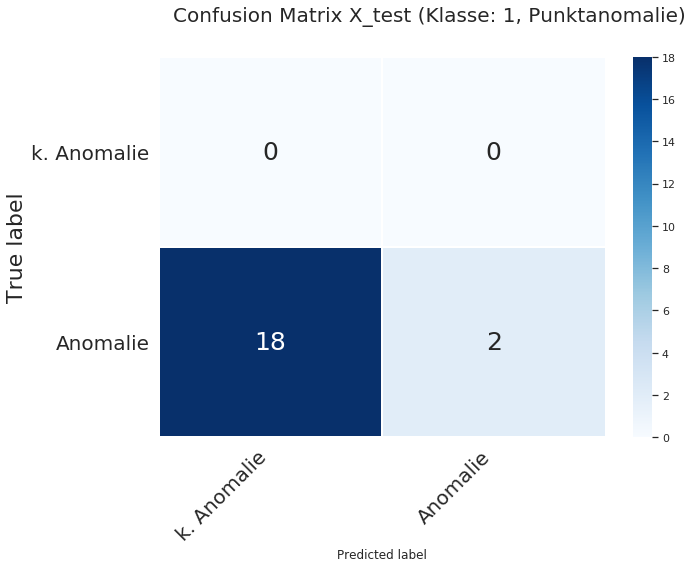

In [32]:
fig = print_confusion_matrix(cm_class_1, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test (Klasse: 1, Punktanomalie)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_test_class_1.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [33]:
cm_class_2 = confusion_matrix(y_class_2, df_x_test_class_2['ano_predictions'])
tn, fp, fn, tp  = cm_class_2.ravel()

In [34]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 95.4788327164181
Precision: 99.99999999956952
Specifity: 0.0
Sensitivity: 95.4788327164181
F1-Score: 97.68713204352883


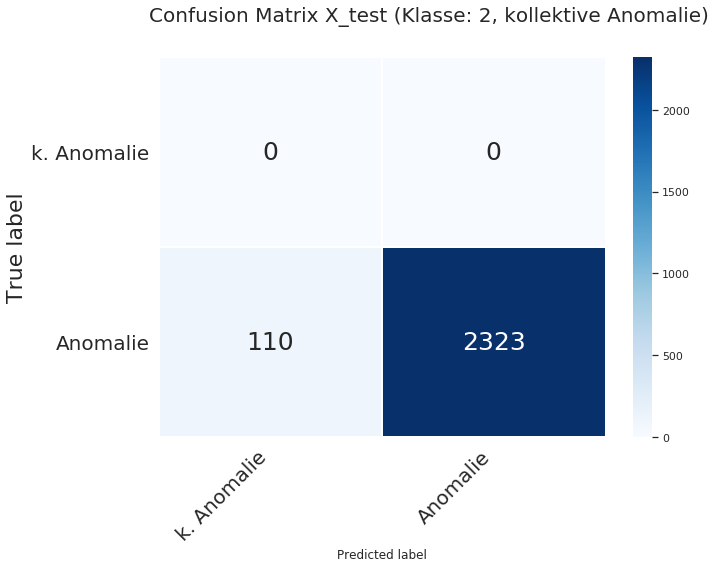

In [35]:
fig = print_confusion_matrix(cm_class_2, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test (Klasse: 2, kollektive Anomalie)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_test_class_2.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [36]:
cm_class_3 = confusion_matrix(y_class_3, df_x_test_class_3['ano_predictions'])
tn, fp, fn, tp  = cm_class_3.ravel()

In [37]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 13.636363633264462
Precision: 99.99999983333333
Specifity: 0.0
Sensitivity: 13.636363633264462
F1-Score: 23.9999999952


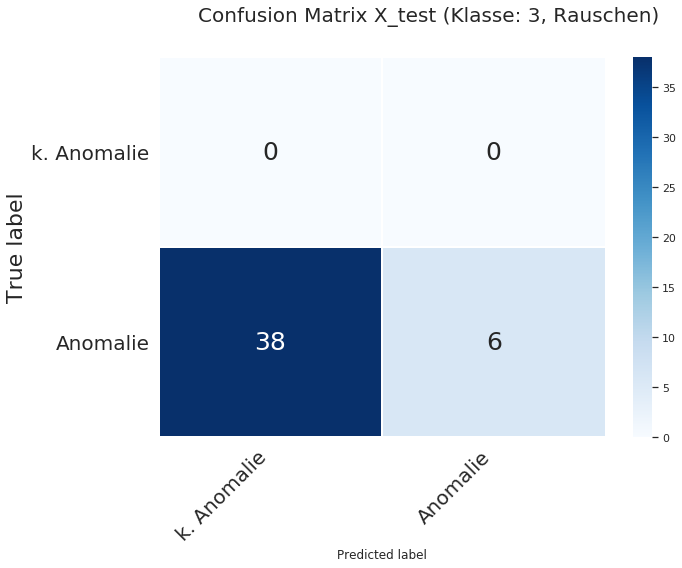

In [38]:
fig = print_confusion_matrix(cm_class_3, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test (Klasse: 3, Rauschen)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_test_class_3.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

## On X_drifted,ano

In [39]:
df_x_drifted_ano = pd.DataFrame(scaled_drifted_anormal)

In [40]:
df_x_drifted_ano.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.361683,-0.340664,-0.195000,-0.226287,-0.533003,-0.619337,-0.464010,-0.465232,-0.463633,-0.448233,-0.934873,-0.937188,0.312905,0.358554,0.733022,-0.412400,-0.934690
1,-0.426634,-0.405138,-0.254874,-0.286832,-0.590971,-0.664934,-0.534886,-0.536075,-0.534497,-0.519722,-0.885071,-0.888276,0.375630,0.423473,0.774954,-0.480219,-0.884749
2,-0.488153,-0.466242,-0.311690,-0.344285,-0.646011,-0.708231,-0.602131,-0.603269,-0.601737,-0.587541,-0.840568,-0.844077,0.435098,0.485023,0.811966,-0.544449,-0.840122
3,-0.546848,-0.524637,-0.365881,-0.399325,-1.556294,-0.748869,-0.666872,-0.667940,-0.666483,-0.652450,-0.799833,-0.803441,0.491931,0.543870,0.845695,-0.605699,-0.799273
4,-0.602720,-0.580341,-0.417474,-0.451976,-1.605610,-0.786874,-0.729136,-0.730112,-0.728764,-0.714477,-0.762977,-0.766593,0.546162,0.600049,0.876147,-0.663961,-0.762314


In [41]:
s_ano_labels_drifted_ano.reset_index(drop=True, inplace=True)

In [42]:
df_x_drifted_ano['anomaly_labels'] = s_ano_labels_drifted_ano

In [43]:
losses_anormal_drifted = []
for val in drifted_anormal_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_anormal_drifted.append(loss.item())
    
s_losses_anormal_drifted = pd.Series(losses_anormal_drifted)

In [44]:
X = s_losses_anormal_drifted.to_numpy()
X = X.reshape(-1, 1)

In [45]:
predictions_anormal_Drifted = []
for val in X:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions_anormal_Drifted.append(pred[0])

In [46]:
df_x_drifted_ano['ano_predictions']  = predictions_anormal_Drifted

In [47]:
df_x_drifted_ano['reconstruction_error'] = s_losses_anormal_drifted

In [48]:
df_x_drifted_ano.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,anomaly_labels,ano_predictions,reconstruction_error
0,-0.361683,-0.340664,-0.195000,-0.226287,-0.533003,-0.619337,-0.464010,-0.465232,-0.463633,-0.448233,-0.934873,-0.937188,0.312905,0.358554,0.733022,-0.412400,-0.934690,0.0,0,0.015504
1,-0.426634,-0.405138,-0.254874,-0.286832,-0.590971,-0.664934,-0.534886,-0.536075,-0.534497,-0.519722,-0.885071,-0.888276,0.375630,0.423473,0.774954,-0.480219,-0.884749,0.0,0,0.011877
2,-0.488153,-0.466242,-0.311690,-0.344285,-0.646011,-0.708231,-0.602131,-0.603269,-0.601737,-0.587541,-0.840568,-0.844077,0.435098,0.485023,0.811966,-0.544449,-0.840122,0.0,0,0.010099
3,-0.546848,-0.524637,-0.365881,-0.399325,-1.556294,-0.748869,-0.666872,-0.667940,-0.666483,-0.652450,-0.799833,-0.803441,0.491931,0.543870,0.845695,-0.605699,-0.799273,2.0,0,0.050032
4,-0.602720,-0.580341,-0.417474,-0.451976,-1.605610,-0.786874,-0.729136,-0.730112,-0.728764,-0.714477,-0.762977,-0.766593,0.546162,0.600049,0.876147,-0.663961,-0.762314,2.0,0,0.050970


In [49]:
df_drifted_ano_class_0 = df_x_drifted_ano[df_x_drifted_ano['anomaly_labels'] == 0.0]
df_drifted_ano_class_1 = df_x_drifted_ano[df_x_drifted_ano['anomaly_labels'] == 1.0]
df_drifted_ano_class_2 = df_x_drifted_ano[df_x_drifted_ano['anomaly_labels'] == 2.0]
df_drifted_ano_class_3 = df_x_drifted_ano[df_x_drifted_ano['anomaly_labels'] == 3.0]

In [50]:
print('Anzahl Samples in Klasse 0: {}'.format(len(df_drifted_ano_class_0)))
print('Anzahl Samples in Klasse 1: {}'.format(len(df_drifted_ano_class_1)))
print('Anzahl Samples in Klasse 2: {}'.format(len(df_drifted_ano_class_2)))
print('Anzahl Samples in Klasse 3: {}'.format(len(df_drifted_ano_class_3)))

Anzahl Samples in Klasse 0: 32543
Anzahl Samples in Klasse 1: 20
Anzahl Samples in Klasse 2: 2433
Anzahl Samples in Klasse 3: 44


In [51]:
df_drifted_ano_class_0['reconstruction_error'].describe()

count    3.254300e+04
mean     3.705971e+05
std      1.025741e+07
min      1.704635e-04
25%      1.914997e-03
50%      6.743561e-03
75%      2.376099e-02
max      4.243665e+08
Name: reconstruction_error, dtype: float64

In [52]:
df_drifted_ano_class_1['reconstruction_error'].describe()

count    2.000000e+01
mean     1.419195e+06
std      6.346797e+06
min      2.180588e-03
25%      6.086120e-03
50%      2.257245e-02
75%      8.632016e-02
max      2.838375e+07
Name: reconstruction_error, dtype: float64

In [53]:
df_drifted_ano_class_2['reconstruction_error'].describe()

count    2433.000000
mean        5.926299
std         3.036416
min         0.050032
25%         5.726341
50%         6.354577
75%         6.934520
max        22.735142
Name: reconstruction_error, dtype: float64

In [54]:
df_drifted_ano_class_3['reconstruction_error'].describe()

count    4.400000e+01
mean     5.594899e+06
std      1.044164e+07
min      1.437105e-03
25%      1.773291e-02
50%      4.033335e-02
75%      5.204387e-01
max      2.586226e+07
Name: reconstruction_error, dtype: float64

In [55]:
y_class_0 = np.zeros(len(df_drifted_ano_class_0))
y_class_1 = np.ones(len(df_drifted_ano_class_1))
y_class_2 = np.ones(len(df_drifted_ano_class_2))
y_class_3 = np.ones(len(df_drifted_ano_class_3))

In [56]:
cm_class_0 = confusion_matrix(y_class_0, df_drifted_ano_class_0['ano_predictions'])
tn, fp, fn, tp  = cm_class_0.ravel()

In [57]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 89.819623267649
Precision: 0.0
Specifity: 99.99999999996578
Sensitivity: 0.0
F1-Score: 0.0


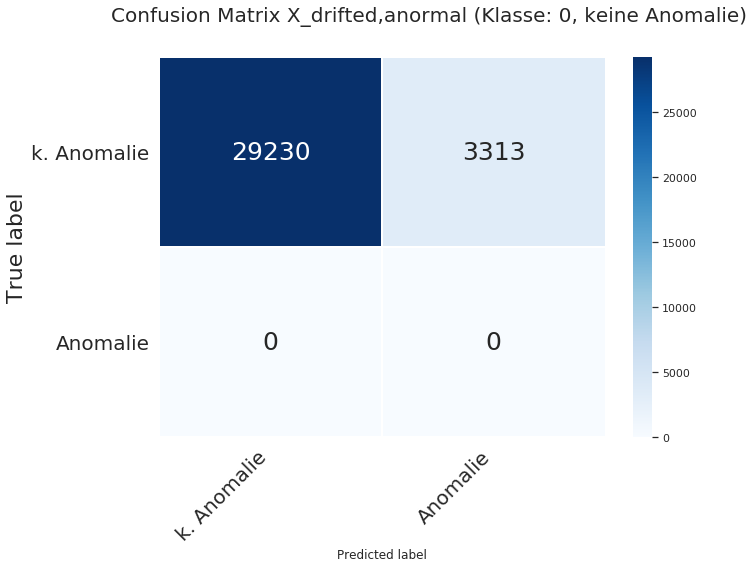

In [58]:
fig = print_confusion_matrix(cm_class_0, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal (Klasse: 0, keine Anomalie)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_drifted_ano_class_0.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [59]:
cm_class_1 = confusion_matrix(y_class_1, df_drifted_ano_class_1['ano_predictions'])
tn, fp, fn, tp  = cm_class_1.ravel()

In [60]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 14.9999999925
Precision: 99.99999966666667
Specifity: 0.0
Sensitivity: 14.9999999925
F1-Score: 26.086956510396973


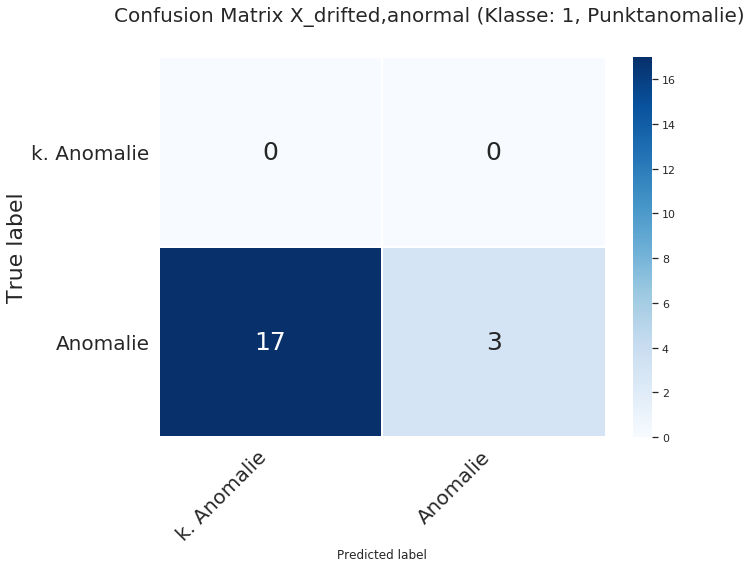

In [61]:
fig = print_confusion_matrix(cm_class_1, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal (Klasse: 1, Punktanomalie)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_drifted_ano_class_1.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [62]:
cm_class_2 = confusion_matrix(y_class_2, df_drifted_ano_class_2['ano_predictions'])
tn, fp, fn, tp  = cm_class_2.ravel()

In [63]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 94.69790382205221
Precision: 99.99999999956599
Specifity: 0.0
Sensitivity: 94.69790382205221
F1-Score: 97.27675744121326


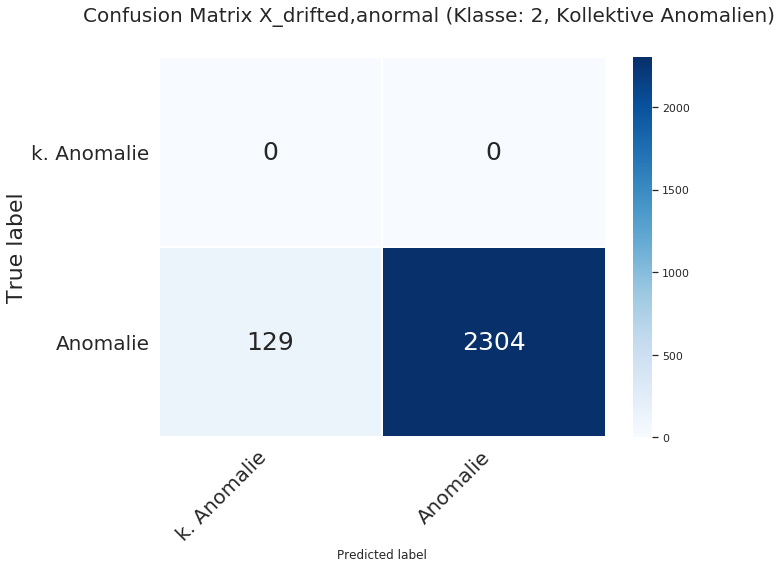

In [64]:
fig = print_confusion_matrix(cm_class_2, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal (Klasse: 2, Kollektive Anomalien)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_drifted_ano_class_2.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [65]:
cm_class_3 = confusion_matrix(y_class_3, df_drifted_ano_class_3['ano_predictions'])
tn, fp, fn, tp  = cm_class_3.ravel()

In [66]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 27.272727266528925
Precision: 99.99999991666667
Specifity: 0.0
Sensitivity: 27.272727266528925
F1-Score: 42.85714284948979


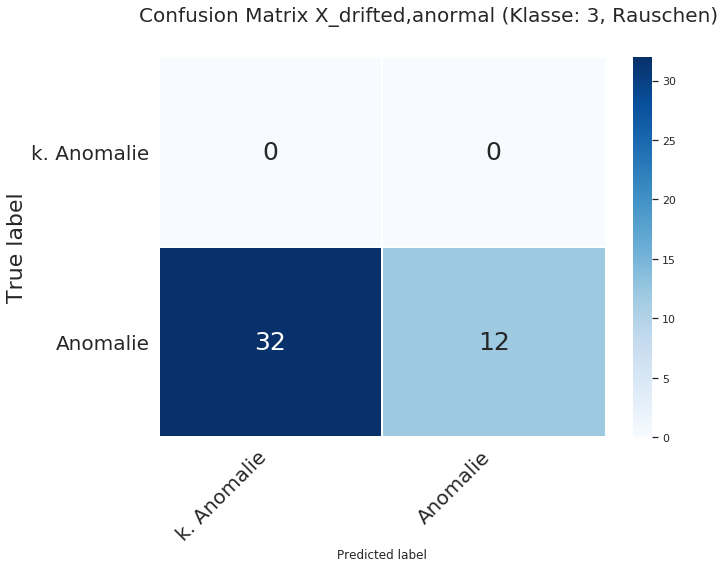

In [67]:
fig = print_confusion_matrix(cm_class_3, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal (Klasse: 3, Rauschen)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_drifted_ano_class_3.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )